# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [286]:
# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [2]:
a = np.array([[1, 0], [10 **20, 1]])
b = np.array([[10 ** (-20), 1], [0, 1 - 10 ** 20]])
c = np.dot(a, b)
print c

[[1e-20 1L]
 [1.0 1L]]


In [3]:
a = np.array([[1., 0], [10 **20, 1.]])
b = np.array([[10 ** (-20), 1.], [0, 1. - (10 ** 20)]])
c = np.dot(a, b)
print c

[[1e-20 1.0]
 [1.0 0.0]]


Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

Теперь проверьте, что будет, если вычислить QR-разложение исходной матрицы и перемножить матрицы $Q$ и $R$.

In [4]:
A = np.array([[10 ** (-20), 1.],[1., 1.]])
a, b = sla.qr(A)
Anew = np.dot(a, b)
Anew

array([[ 0.,  1.],
       [ 1.,  1.]])

**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$

Но что, если это отношение велико?

# **Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [5]:
def pivot_matrix(m):
    n = len(m)    
    ind = [[float(i == j) for i in xrange(n)] for j in xrange(n)]
    ind = np.asarray(ind, dtype = np.float)
    return ind
    for j in xrange(n):
        row_ind = np.argmax(np.abs(m[j:, j])) + j     
        if row_ind != j:
            ind[j], ind[row_ind] = ind[row_ind], ind[j]
    return ind

def lu_decomposition(a):
    n = a.shape[0]
    L = np.zeros(a.shape)
    U = np.zeros(a.shape)

    P = pivot_matrix(a)
    PA = np.dot(P, a)
    #print PA
    for j in xrange(n):
        L[j][j] = 1.0
        for i in xrange(j+1):
            s1 = np.sum((U[:, j] * L[i, :])[:i])
            #print s1
            U[i][j] = PA[i][j] - s1

        for i in xrange(j, n):
            s2 = np.sum((U[:,j] * L[i, :])[:j])
            #print s2
            L[i][j] = (PA[i][j] - s2) / U[j][j]
        #print L, U


    return (P, L, U)

In [6]:
def getQRDecomposition(a):
    u = []
    u.append(a[0, :].copy())
    #print a
    for i in range(1, len(a)):
        bi = a[i , :].copy()
        for j in range(len(u)):
            bi -= (np.sum(a[i, :] * u[j])) / (np.sum(u[j] ** 2)) * u[j]
        #bi /= np.sqrt(np.sum(bi * bi))
        u.append(bi)
    #print a
    for i in range(len(u)):
        u[i] /= np.sqrt(np.sum(u[i] ** 2))
    Q = np.asarray(u, dtype = np.float)
    #print a
    R = np.dot(Q.T, a)
    return Q, R

In [7]:
a = np.zeros((500, 500))
for i in range(500):
    for j in range(500):
        if i == j:
            a[i][j] = 1
        elif j == 499:
            a[i][j] = 1
        elif i > j:
            a[i][j] = -1
P, L, U = sla.lu(a)
L = np.dot(P, L)
for i in range(len(P)):
    for j in range(len(P)):
        if i == j:
            assert P[i][j] == 1.
        else:
            assert P[i][j] == 0
#print a
Q, R = sla.qr(a)
deltaLU = np.sqrt(np.sum((a - np.dot(L, U)) ** 2))
deltaQR = np.sqrt(np.sum((a - np.dot(Q, R)) ** 2))
print 'Delta LU decomposition: ', deltaLU
print 'Delta QR, decomposition: ', deltaQR

Delta LU decomposition:  2.53295195207e+76
Delta QR, decomposition:  1.55336004413e-12


К счастью, на практике так редко бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [11]:
###
# Your function here
def my_pascal(size):
    a = np.zeros((size, size))
    a[0, :] = np.ones(size)
    a[:, 0] = np.ones(size)
    for i in xrange(1, size):
        for j in xrange(1, size):
            a[i][j] = a[i - 1][j] + a[i][j - 1]
    return a
    
###

A = my_pascal(30)
p, l, u = sla.lu(A)
#print A
#print np.dot(L, U)
#print U[4]
#print np.diag(A, )
p, l, u = sla.lu(A)
print np.sqrt(np.sum((A - np.dot(np.dot(p, l), u)) ** 2))
#print A

2.31466102561


Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [12]:
print(sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x)
x1 = sla.solve(A, b)
print(sla.norm(x1 - x))

-3.01736842766e+49
492533426.521


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [13]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print sla.norm(x2 - x)

965320173.567


Объясните полученные неприятные результаты.

----
*Ваш ответ*

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [72]:
def naive_solve(A, b):
    return np.dot(sla.inv(A), b)

def standart_solve(A, b):
    return sla.solve(A, b)

def cholesky_simple(A, b):
    lower = sla.cho_factor(A, lower = True)[0]
    y = sla.solve_triangular(lower, b, lower = True)
    x = sla.solve_triangular(lower.T, y, lower = False)
    return x
    
def cholesky_scipy(A, b):
    lower = sla.cho_factor(A)
    #lower = np.asarray(lower)
    return sla.cho_solve(lower, b)


Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [543]:
def gen_matrix(sz):
    a = np.abs(np.random.randn(sz, sz)) * 0.001
    #for i in range(sz):
    #    for j in range(i + 1, sz):
    #        a[i][j] = 0
    #print a
    a += np.eye(N = sz) * 0.0001
    return np.dot(a, a.T)
sz = 20
A = gen_matrix(sz)
b = np.abs(np.random.randn(sz))

In [531]:
x1 = naive_solve(A, b)
x2 = standart_solve(A, b)
x3 = cholesky_simple(A, b)
x4 = cholesky_scipy(A, b)
print sla.norm(x1 - x2)
print sla.norm(x1 - x3)
print sla.norm(x1 - x4)

3.40399660292e-12
5.55722493248e-08
6.48527694217e-08


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

## график зависимости времени от роста размера матрицы А при фиксированном числе правых частей

In [191]:
from timeit import timeit

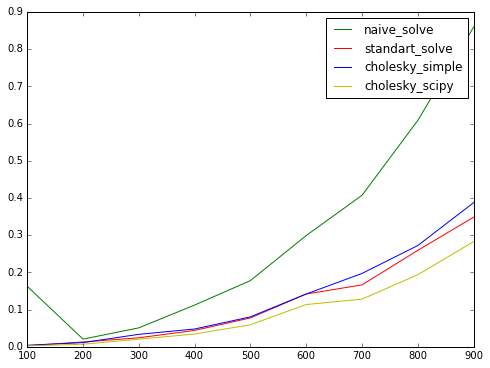

In [192]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(100, 1000, 100)
for sz in range(100, 1000, 100):
    A = gen_matrix(sz)
    b = []
    for j in range(10):
        b.append(np.abs(np.random.randn(sz)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('matrix size')
plt.ylabel('time for 10 b parts')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

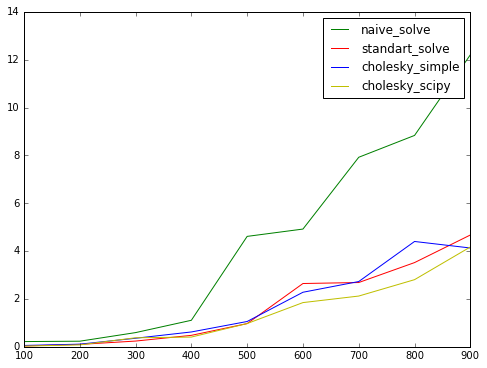

In [193]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(100, 1000, 100)
for sz in range(100, 1000, 100):
    A = gen_matrix(sz)
    b = []
    for j in range(100):
        b.append(np.abs(np.random.randn(sz)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('matrix size')
plt.ylabel('time for 100 b parts')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

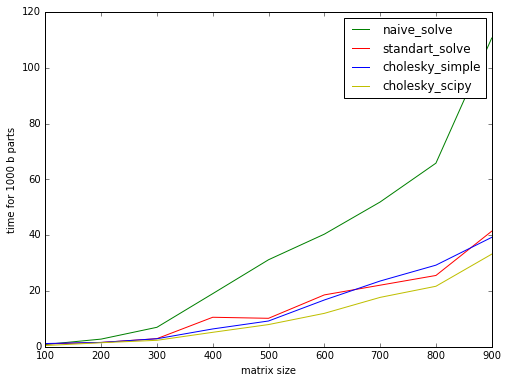

In [194]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(100, 1000, 100)
for sz in range(100, 1000, 100):
    A = gen_matrix(sz)
    b = []
    for j in range(1000):
        b.append(np.abs(np.random.randn(sz)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('matrix size')
plt.ylabel('time for 1000 b parts')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

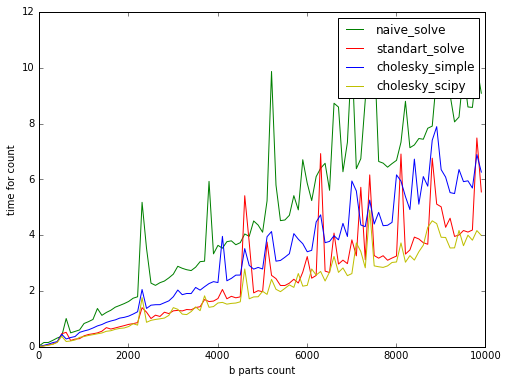

In [196]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(10, 10000, 100)
A = gen_matrix(100)
for sz in range(10, 10000, 100):
    b = []
    for j in range(sz):
        b.append(np.abs(np.random.randn(100)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('b parts count')
plt.ylabel('time for count')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

In [544]:
#Заготовка:
def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод*
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    d = S.shape[0]
    lowerS = sla.cho_factor(S, lower = True)[0]
    for i in range(d):
        for j in range(i + 1, d):
            lowerS[i][j] = 0.
    det = 1
    for i in range(d):
        det *= lowerS[i][i] * lowerS[i][i]
    lowerInv = sla.inv(lowerS)
    normalizeX = X - m
    #print sla.norm(sla.inv(S) - np.dot(lowerInv.T, lowerInv))
    #print np.dot(lowerInv.T, lowerInv).shape
    #print normalizeX.shape
    #print np.dot(normalizeX, np.dot(lowerInv.T, lowerInv)).shape
    answer = []
    const_add = d * np.log(2 * np.pi) + np.log(det)
    Sinv = np.dot(lowerInv.T, lowerInv)
    for i in range(normalizeX.shape[0]):
        answer.append(const_add + np.dot(np.dot(normalizeX[i], Sinv), normalizeX[i].T))
    #answer = np.dot(np.dot(normalizeX, np.dot(lowerInv.T, lowerInv)), normalizeX.T)
    #answer = np.sum(answer, axis = 0)
    answer = np.asarray(answer, dtype = np.float)
    #answer += d * np.log(2 * np.pi) + np.log(det)
    return -answer * 0.5
    #y = sla.solve_triangular(lower, b, lower = True)
    #x = sla.solve_triangular(lower.T, y, lower = False)

Сгенерируйте выборку из нормального распределения со случайными параметрами для небольшого $D$ с помощью функции `scipy.stats.multivariate_normal.rvs` и сравните на этой выборке результат работы вашего алгоритма с результатом стандартной функции `scipy.stats.multivariate_normal.logpdf`

In [545]:
import scipy.stats

In [546]:
D = 30
covMatrix = gen_matrix(D)
mean = np.random.randn(D)
X = scipy.stats.multivariate_normal.rvs(mean, covMatrix, 100)
logPScipy = scipy.stats.multivariate_normal.logpdf(X, mean, covMatrix)
logPMyImpl = my_multivariate_normal_logpdf(X, mean, covMatrix)
print sla.norm(logPScipy - logPMyImpl)
#print logPScipy
#print logPScipy -logPMyImpl
#print logPMyImpl.shape
#print logPScipy.shape

2.92163560731e-12


Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [547]:
from timeit import timeit

In [554]:
x = np.arange(100, 500, 100)
time_scipy = []
time_my_impl = []
for d in range(100, 500, 100):
    D = d
    covMatrix = gen_matrix(D)
    mean = np.random.randn(D)
    #print sla.det(covMatrix)
    X = scipy.stats.multivariate_normal.rvs(mean, covMatrix, 100)
    time_scipy.append(timeit('scipy.stats.multivariate_normal.logpdf(X, mean, covMatrix)', number = 1, setup = 'from __main__ import naive_solve, X, mean, covMatrix, scipy'))
    time_my_impl.append(timeit('my_multivariate_normal_logpdf(X, mean, covMatrix)', number = 1, setup = 'from __main__ import X, mean, covMatrix, scipy, my_multivariate_normal_logpdf'))

    #logPScipy = scipy.stats.multivariate_normal.logpdf(X, mean, covMatrix)
    #logPMyImpl = my_multivariate_normal_logpdf(X, mean, covMatrix)
    #print sla.norm(logPScipy - logPMyImpl)

0.0
0.0
0.0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


0.0


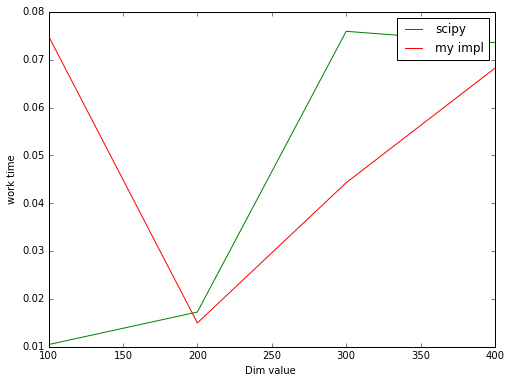

In [555]:
#print len(time_scipy)
#print len(time_my_impl)
#print len(x)
plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_scipy, c = 'g')
line2, = plt.plot(x, time_my_impl, c = 'r')
plt.xlabel('Dim value ')
plt.ylabel('work time')
plt.legend([line1, line2], ['scipy', 'my impl'])
plt.show()

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

## Часть 3. Разреженные матрицы

Матрица называется разреженной, если в ней мало ненулевых элементов.

Например, если в матрице $n\times n$ порядка $O(n)$ ненулевых элементов, она является разреженной.

Зачастую размерность разреженных матриц, возникающих в реальных задачах, так велика, что хранить её в памяти вместе с нулями - непозволительная роскошь. Есть несколько экономичных методов хранения:

- `Dictionary of Keys` (`DOK`) - словарь `(i,j):element`. 

    $\color{green}{\oplus}$ быстрое добавление элементов с произвольными индексами,
  
    $\color{red}{\ominus}$ любые другие операции будут производиться медленно.


- `List of Lists` (`LIL`) - матрица хранится построчно: в виде двух массивов `[l_1,...,l_s]` и `[v_1,...v_s]`, где `l_i` - список номеров столбцов, в которых в i-й строке находится ненулевой элемент, а `v_i` - список соответствующих значений. В целом, подходит для создания в высокой степени разреженной матрицы. Когда все элементы добавлены, лучше перевести в формат `CSR` или `CSC`.

    $\color{green}{\oplus}$ добавление за линейное время, 
    
    $\color{green}{\oplus}$ быстрый доступ к строкам матрицы, 
    
    $\color{red}{\ominus}$ может требовать слишком много памяти (для создания матриц повышенной плотности используйте `COO`).

    
- `Coordinate List` (`COO`) - хранятся тройки `(row, column, value)`  или три массива \texttt{rows,\ columns,\ values}. При этом тройка с одинаковым началом `(row, column)` может быть не одна; при преобразовании к другому типу значения `value` суммируются.

    $\color{green}{\oplus}$ быстрое добавление новых элементов,
    
    $\color{red}{\ominus}$ для всего остального лучше перевести в другой формат.
    
    
- `Compressed Sparse Row/Column storage` (`CSR/CSC`) - разберём на примере `CSR`. Хранятся три массива: `values`, `indptr` и `indices`. В массиве `values` хранятся все ненулевые элементы матрицы, упорядоченные лексикографически по паре (строка, столбец); `indptr[i]` - индекс начала `i`-й строки, `indices[indptr[i]:indptr[i+1]-1]` - номера столбцов соответствующих элементов.

    $\color{green}{\oplus}$ быстрое выполнение арифметических операций,
    
    $\color{green}{\oplus}$ быстрый доступ к строкам для `CSR` и к столбцам для `CSC`,
    
    $\color{red}{\ominus}$ очень медленный доступ к столбцам для `CSR` и к строкам для `CSC`,
    
    $\color{red}{\ominus}$ медленное добавление/удаление элементов.
  

Главный вывод - не надо один и тот же формат использовать для разных целей!

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как эти возможности реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.0** Загрузите файл `sparse_matrix1.mtx`

In [ ]:
import scipy.io as sio

In [ ]:
A = sio.mmread(r'...\sparse_matrix1.mtx') # Please type right folder name! 

С помощью следующей функции можно посмотреть, как расположены ненулевые элементы матрицы:

In [ ]:
plt.spy(A, marker='.', markersize=0.4)

В каком из пяти форматов хранится матрица? Для ответа на этот вопрос воспользуйтесь функцию `type`.

Сколько в ней ненулевых элементов?

Посмотрим, сколько времени занимает преобразование между разными форматами.

In [5]:
import pandas as pd
import timeit

A_dok = A.todok()
A_lil = A.tolil()
A_csc = A.tocsc()
A_csr = A.tocsr()

conversion_times = pd.DataFrame(
    index=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    columns=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    data={
        'COO': [
            np.nan,
            timeit.timeit('A.todok()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tolil()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsr()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsc()', 'from __main__ import A', number=100) / 100,
               ],
        'DOK': [
            timeit.timeit('A_dok.tocoo()', 'from __main__ import A_dok', number=100) / 100,
            np.nan,
            timeit.timeit('A_dok.tolil()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsr()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsc()', 'from __main__ import A_dok', number=100) / 100,
               ],
        'LIL': [
            timeit.timeit('A_lil.tocoo()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.todok()', 'from __main__ import A_lil', number=100) / 100,
            np.nan,
            timeit.timeit('A_lil.tocsr()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.tocsc()', 'from __main__ import A_lil', number=100) / 100,
               ],
        'CSR': [
            timeit.timeit('A_csr.tocoo()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.todok()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.tolil()', 'from __main__ import A_csr', number=100) / 100,
            np.nan,
            timeit.timeit('A_csr.tocsc()', 'from __main__ import A_csr', number=100) / 100,
               ],
        'CSC': [
            timeit.timeit('A_csc.tocoo()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.todok()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tolil()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tocsr()', 'from __main__ import A_csc', number=100) / 100,
            np.nan,
               ],
    }
    )

conversion_times.T

,COO,DOK,LIL,CSR,CSC
COO,NaN,0.064994,0.017649,0.000432,0.000536
DOK,0.104156,NaN,0.155717,0.103632,0.106420
LIL,0.014274,0.081863,NaN,0.014238,0.014916
CSR,0.000810,0.067233,0.013615,NaN,0.000494
CSC,0.000709,0.070901,0.015557,0.000509,NaN


Как вы можете убедиться, быстрее всего преобразования происходят между форматами `COO`, `CSR` и `CSC`, а хуже всего дела обстоят с форматом `DOK`: все преобразования из него занимают чудовищно много времени.

**Задание 3.1 (0,5 балла)** Почему преобразование из формата `LIL` в формат `CSR` занимает такую пропасть времени?

----
*Ваш ответ:*

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою список из нескольких сотен тысяч чеков (списков покупок). Для того, чтобы определить, какие товары чаще покупают вместе, вы решили построить матрицу, строки и столбцы которой соответствуют различным товарам (предположим, что число различных товаров тоже измеряется сотнями тысяч), а в клетке с "номером" $(g_1, g_2)$ стоит число

$\log_2{\frac{N\cdot c(g_1 \& g_2)}{c(g_1)c(g_2)}},$

где $c(g_i)$ --- количество чеков, содержащих товар $g_i$, $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара, $N$ --- общее число чеков. В каком формате вы будете создавать эту (очевидно разреженную) матрицу? Почему?

----
*Ваш ответ:*

Напишите максимально эффективный код, создающий эту матрицу:

In [ ]:
def CreateMatrix(receipts):
    # Your code here
    
    for receipt in receipts:
        # Your code here

**Задание 3.3 (1 балл)** В каком из форматов `LIL` и `COO` умножение на вектор происходит быстрее? Почему? Проведите эксперименты. Можете воспользоваться функцией `scipy.sparse.random` для создания случайных разреженных матриц.

Насколько быстрее с аналогичной задачей будут справляться форматы `CSC` и `CSR`?

----
*Ваш ответ:*

## Часть 4. Итерационные методы

В этом задании вам предлагается поработать с итеративными методами решения систем уравнений.

Соответствующие функции реализованы в пакете `scipy.sparse.linalg` (http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.linalg.html). Пожалуйста, читайте документацию перед их применением!

В этом задании вам предстоит поближе познакомиться с двумя итеративными методами:

1. **(L)GMRES** (мы настоятельно рекомендуем использовать оптимизированную функцию `scipy.sparse.linalg.lgmres`, даже если вам нужен обыкновенный **GMRES**)

2. **CG** (вызывается функцией `scipy.sparse.linalg.cg`)

*Замечания*:
1. Функции `scipy.sparse.linalg.lgmres` и `scipy.sparse.linalg.cs` устроены так, что могут решать уравнения только с векторной правой частью.
2. Внимательно ознакомьтесь с параметрами (у функции `scipy.sparse.linalg.lgmres` их очень много) и обратите внимание на формат вывода функций.
3. Вы можете захотеть выводить/сохранять что-нибудь после каждой итерации. Для этого существует параметр `callback`: это функция с сигнатурой `callback(xk)`, вызываемая на каждой итерации. Её аргумент `xk` - это текущее приближение $x_k$. Вот пример вызова функции `lgmres`, печатающей норму текущего приближения:

In [ ]:
x = spla.gmres(A, b, callback=lambda xk: print(sla.norm(xk))

Если вы захотите что-нибудь сохранять по ходу дела, логичнее использовать для этого класс. Ниже приводим пример класса, считающего число итераций и выводящего (если указан флаг `disp`) номер каждой итерации на печать, а также запоминающего все промежуточные приближения (не делайте так для больших систем! вам может не хватить памяти):

In [ ]:
class iterative_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.all_x = [] # Please discard this if you solve large systems!!!
        
    def __call__(self, xk=None):
        self.niter += 1
        self.all_x.append(xk) # Please discard this if you solve large systems!!!
        if self._disp:
            print('iter %3i' % (self.niter))
            
my_counter = gmres_counter() # We need to create an instance of the class

x = spla.gmres(A, b, callback=my_counter)

print(my_counter.niter) # Will print total number of iterations

**Задание 4.1 (3 балла)** Довольно игр! Пора решать большие системы. Загрузите матрицу из файла `large_system.mtx` (она симметричная и положительно определённая) и сгенерируйте случайную правую часть. Решите систему с помощью функции `scipy.sparse.linalg.spsolve` (сильно оптимизированный "точный" решатель) и с помощью итеративных методов `LGMRES` и `CG`. Сравните скорость работы этих методов.

Постарайтесь обогнать функцию `spsolve`, применяя предобуславливание с помощью одной итерации метода Якоби или с помощью неполного LU-разложения. Для ILU постарайтесь подобрать оптимальные значения коэффициентов `fill_factor` и `drop_tol`.

*Замечание.* Если матрица-предобуславливатель $P$ не совсем уж тривиальная, не надо её обращать и умножать на исходную матрицу!

В каждом из итеративных методов можно включить предобуславливание с помощью параметра `M`. В качестве этого параметра нужно передать либо матрицу $P^{-1}$, либо **линейный оператор**, осуществляющий умножение вектора на $P^{-1}$. По понятным причинам второе гораздо правильнее. Делается это следующим образом. Например, если вы хотите ввести предобуславливание с конкретной матрицей $P$ для решения системы $Ax = b$:

In [ ]:
M = spla.LinearOperator(A.shape, lambda x: spla.spsolve(P, x))

x = spla.lgmres(A, b, M=M)

А вот как это работает для неполного LU-разложения:

In [ ]:
my_ILU = spla.spilu(A, '''Add your parameters here''')
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))

x = spla.lgmres(A, b, M=M)

Обратите внимание, что `my_ILU` --- это не просто tuple из четырёх матриц (`spilu` делает разложение вида $P_1AP_2 = LU$, где $P_i$ --- матрицы перестановок). В самом деле, как вы уже, наверное, поняли, в мире больших размерностей иметь матрицу --- это зачастую бесполезное или даже вредное занятие. Гораздо ценнее уметь быстро решать систему с этой матрицей. Поэтому `my_ILU` --- это в первую очередь не разложение (впрочем, матрицы при желании тоже можно извлечь), а оптимизированный решатель `solve`.

In [ ]:
# Your solution here

## Часть 5. Матричные дифференцирования

**Задача 5.1 (1 балл)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

**Задача 5.2 (0.5 балла)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

**Задача 5.3 (0.5 балла)** Найдите производную

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

**Задача 5.4 (1 балл)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.